# Experiment 6

## Goal - Joint optimization of 4 parameters in the FHN model through gradient descent

make FHN functions available

In [1]:
import sys
sys.path.insert(0, '../../')

import modules

In [2]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
from os import path, getcwd
import time
import imageio
import random

set device

In [3]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate data

In [5]:
grid = t.zeros((2, 64, 64), device=device)
grid[:] = 25
grid[0, 29:35] = 40

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 50
num_steps = 50_000
DA = 0.1
DB = 0.4

generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
    create_vis=False,
    save_steps=True,
    create_seq=False,
)


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 50000/50000 [07:28<00:00, 111.56it/s]


use last datapoint from the simulation as reference state

In [6]:
data_dir = path.join(getcwd(), "data", "1675164571.9021132")
ref_state = t.load(path.join(data_dir, "batch_500", "0.pt"), map_location=device)

torch.Size([2, 64, 64])


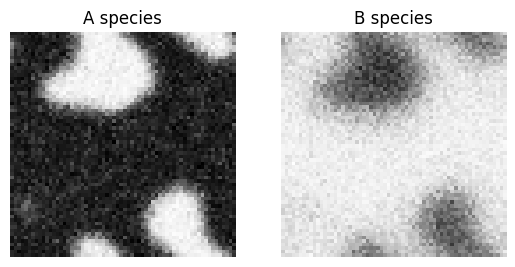

In [7]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

define a distance function

In [8]:
def loss_fn(X, Y):
    return t.log(t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2)))

initialize parameters

In [9]:
from torch.distributions import uniform
param_sampler = uniform.Uniform(0,1)

k1 = param_sampler.sample().to(device)
k2 = param_sampler.sample().to(device)
k3 = param_sampler.sample().to(device)
DB = param_sampler.sample().to(device)

define training function

In [10]:
DA = t.tensor(0.1, device=device)
gamma = 0.005
N = 50

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

k1_vals = [k1.detach().cpu().numpy()]
k2_vals = [k2.detach().cpu().numpy()]
k3_vals = [k3.detach().cpu().numpy()]
DB_vals = [DB.detach().cpu().numpy()]
losses = []
grads_k1 = []
grads_k2 = []
grads_k3 = []
grads_DB = []

In [19]:
for i in tqdm(range(1000)):
    X = ref_state.detach().clone()
    
    k1.requires_grad_()
    k2.requires_grad_()
    k3.requires_grad_()
    DB.requires_grad_()
    
    # Make predictions for this batch
    for sim_step in range(1200):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)
        
    # Compute the loss and its gradients
    loss = loss_fn(ref_state, X)
    grad_k1, grad_k2, grad_k3, grad_DB = t.autograd.grad(loss, (k1, k2, k3, DB))

    k1 = k1 - 0.1 * grad_k1
    k2 = k2 - 0.001 * grad_k2
    k3 = k3 - 0.01 * grad_k3
    DB = DB - 0.01 * grad_DB
            
    with t.no_grad():
        k1 = k1.clamp(0, 1)
        k2 = k2.clamp(0, 1)
        k3 = k3.clamp(0, 1)
        DB = DB.clamp(0, 1)
    
    k1_vals.append(k1.detach().cpu().numpy())
    k2_vals.append(k2.detach().cpu().numpy())
    k3_vals.append(k3.detach().cpu().numpy())
    DB_vals.append(DB.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    grads_k1.append(grad_k1.detach().cpu().numpy())
    grads_k2.append(grad_k2.detach().cpu().numpy())
    grads_k3.append(grad_k3.detach().cpu().numpy())
    grads_DB.append(grad_DB.detach().cpu().numpy())

100%|██████████| 1000/1000 [5:22:26<00:00, 19.35s/it]  


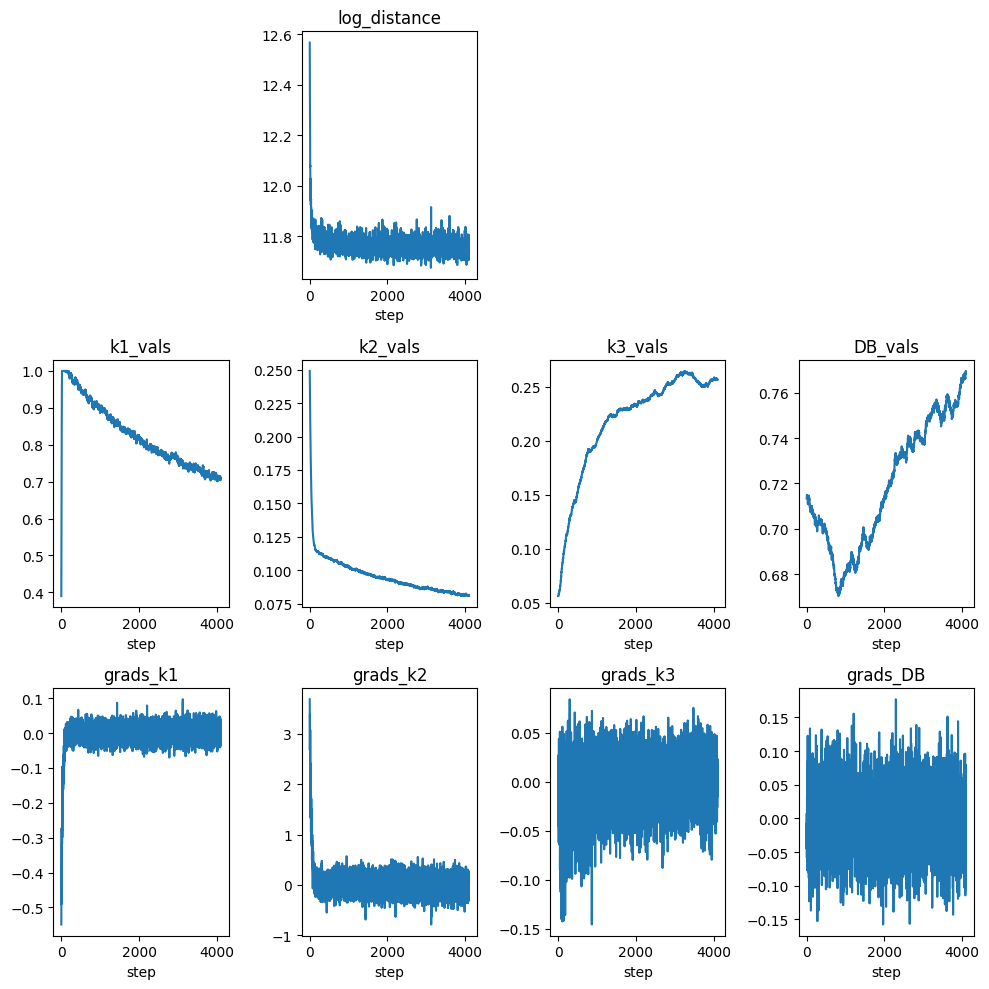

In [20]:
fig, axs = plt.subplots(3,4, figsize=(10,10))

num_steps = 4100

axs[0,1].plot(np.arange(num_steps), losses)
axs[0,1].set_title("log_distance")
axs[0,1].set_xlabel("step")
axs[0,0].axis("off")
axs[0,2].axis("off")
axs[0,3].axis("off")

axs[1,0].plot(np.arange(num_steps+1), k1_vals)
axs[1,0].set_title("k1_vals")
axs[1,0].set_xlabel("step")
axs[2,0].plot(np.arange(num_steps), grads_k1)
axs[2,0].set_title("grads_k1")
axs[2,0].set_xlabel("step")

axs[1,1].plot(np.arange(num_steps+1), k2_vals)
axs[1,1].set_title("k2_vals")
axs[1,1].set_xlabel("step")
axs[2,1].plot(np.arange(num_steps), grads_k2)
axs[2,1].set_title("grads_k2")
axs[2,1].set_xlabel("step")

axs[1,2].plot(np.arange(num_steps+1), k3_vals)
axs[1,2].set_title("k3_vals")
axs[1,2].set_xlabel("step")
axs[2,2].plot(np.arange(num_steps), grads_k3)
axs[2,2].set_title("grads_k3")
axs[2,2].set_xlabel("step")

axs[1,3].plot(np.arange(num_steps+1), DB_vals)
axs[1,3].set_title("DB_vals")
axs[1,3].set_xlabel("step")
axs[2,3].plot(np.arange(num_steps), grads_DB)
axs[2,3].set_title("grads_DB")
axs[2,3].set_xlabel("step")

fig.tight_layout()
plt.show()